### Import Packages

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

print(f"Using {device} device")

Using cuda device


### Preprocessing and downloading the dataset

In [2]:
#Preprocessing
transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loading the CIFAR-10 dataset:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar)

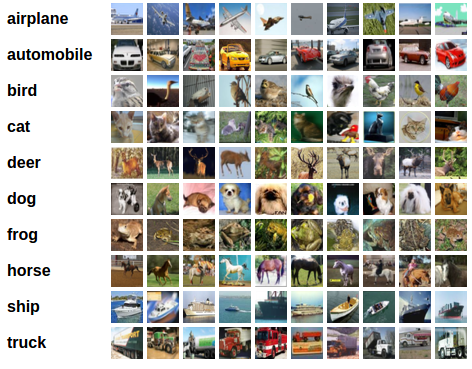

### Torch data loaders

In [3]:
#Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

### Teacher Model Class

In [4]:
# Deeper neural network class to be used as teacher:
class DeepNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DeepNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### Student Model Class

In [5]:
# Lightweight neural network class to be used as student:
class LightNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

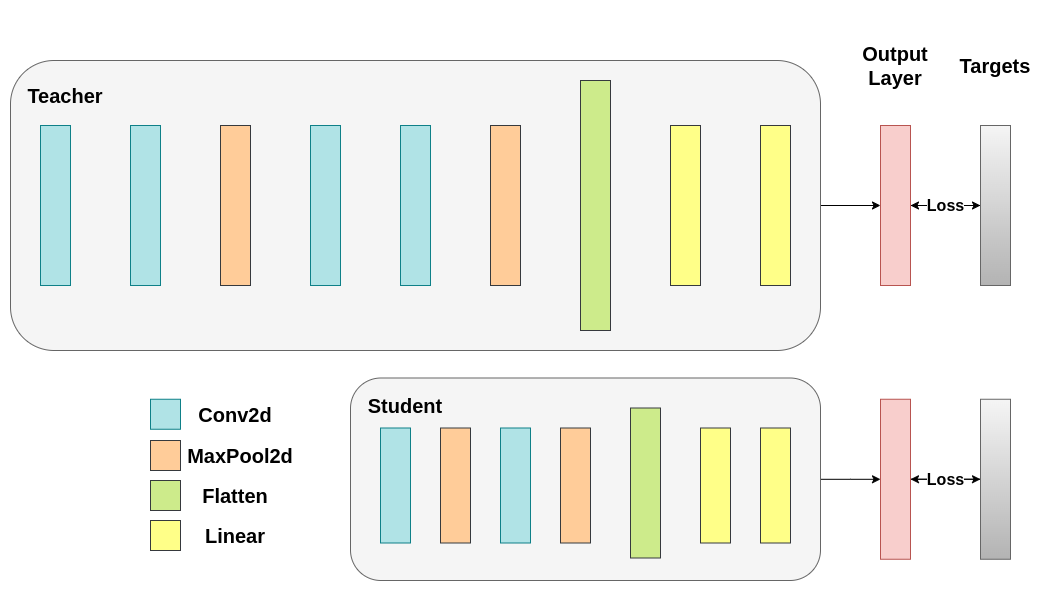

### Training Step

In [6]:
def train(model, train_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
            # labels: The actual labels of the images. Vector of dimensionality batch_size
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

### Testing Model

In [7]:
def test(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

### Teacher Training

In [8]:
torch.manual_seed(42)
nn_deep = DeepNN(num_classes=10).to(device)
train(nn_deep, train_loader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_deep = test(nn_deep, test_loader, device)

Epoch 1/10, Loss: 1.3289424319706304
Epoch 2/10, Loss: 0.8676103257462192
Epoch 3/10, Loss: 0.6794845167633212
Epoch 4/10, Loss: 0.5368961584385094
Epoch 5/10, Loss: 0.4118147258792082
Epoch 6/10, Loss: 0.30502763051358633
Epoch 7/10, Loss: 0.22460008763215122
Epoch 8/10, Loss: 0.167645555894698
Epoch 9/10, Loss: 0.13992839265624277
Epoch 10/10, Loss: 0.11686838329162287
Test Accuracy: 75.04%


### Declaring the light models

In [9]:
# Instantiate the lightweight network:
torch.manual_seed(42)
nn_light = LightNN(num_classes=10).to(device)

torch.manual_seed(42)
new_nn_light = LightNN(num_classes=10).to(device)

# Print the norm of the first layer of the initial lightweight model
print("Norm of 1st layer of nn_light:", torch.norm(nn_light.features[0].weight).item())
# Print the norm of the first layer of the new lightweight model
print("Norm of 1st layer of new_nn_light:", torch.norm(new_nn_light.features[0].weight).item())

Norm of 1st layer of nn_light: 2.327361822128296
Norm of 1st layer of new_nn_light: 2.327361822128296


### Difference between the parameters

In [10]:
total_params_deep = "{:,}".format(sum(p.numel() for p in nn_deep.parameters()))
print(f"DeepNN parameters: {total_params_deep}")
total_params_light = "{:,}".format(sum(p.numel() for p in nn_light.parameters()))
print(f"LightNN parameters: {total_params_light}")

DeepNN parameters: 1,186,986
LightNN parameters: 267,738


### Student Training

In [11]:
train(nn_light, train_loader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_light_ce = test(nn_light, test_loader, device)

Epoch 1/10, Loss: 1.4701405723991297
Epoch 2/10, Loss: 1.1579383518689734
Epoch 3/10, Loss: 1.026408637880974
Epoch 4/10, Loss: 0.9243800323027784
Epoch 5/10, Loss: 0.8512698062850387
Epoch 6/10, Loss: 0.7842016396924968
Epoch 7/10, Loss: 0.7183179212043352
Epoch 8/10, Loss: 0.6612913655045697
Epoch 9/10, Loss: 0.6067937835860435
Epoch 10/10, Loss: 0.5567766147501328
Test Accuracy: 70.48%


### Comparing Student vs Teacher

In [12]:
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy: {test_accuracy_light_ce:.2f}%")

Teacher accuracy: 75.04%
Student accuracy: 70.48%


### How to make knowledge distillation run?

- Both networks output a probability distribution over our classes. 
Therefore, the two networks share the same number of output neurons. 

- The method works by incorporating an additional loss into the traditional cross entropy loss, which is based on the softmax output of the teacher network.

- Output activations of a properly trained teacher network carry additional information that can be leveraged by a student network during training.


**Why soft targets (i.e., the full probability distribution output by a teacher model) can be more useful than hard targets (just the correct class label) when training a student model?**

Even the low probabilities assigned to incorrect classes in a teacher model’s output can reveal useful information. These small values help express how the teacher understands relationships between classes.

*Example:*
*In CIFAR-10 (a dataset of 10 image classes like airplanes, trucks, dogs, etc.), the teacher might classify a truck image like this:*

```
Truck: 0.80 
Automobile: 0.15 
Airplane: 0.04
Dog: 0.01
```
This shows the teacher believes the truck image is somewhat like an automobile or airplane, but very unlikely to be a dog. These relative similarities (the ratios between small probabilities) help shape a richer learning signal for the student.

<br>                                                                                    

**Deep networks aim to map similar inputs (like trucks and cars) to similar representations in feature space. The soft targets help enforce this because they encode class similarities, not just "right vs. wrong".**

So instead of saying “this is a truck” (hard label), the teacher says “this is mostly a truck, a bit like a car, and very little like a dog” — giving the student a sense of how to think about the image.

<br>

**Cross-entropy loss (used for hard labels) focuses only on making the correct class probability high, ignoring the rest. This means:**

- Probabilities for other (incorrect) classes are squashed down close to zero.

- The gradients from those tiny values don’t affect the weights much.

So, the model doesn’t learn the structure or relationships between classes as effectively.

<br>

<b><p>Soft targets carry extra information about how the teacher understands relationships between classes. <br>
These subtle signals — even in the "small" probabilities — help guide the student model to learn more <br>
than just the correct label. Standard cross-entropy ignores that richness, which is why knowledge <br>
distillation works better with softened output distributions.</p><b>


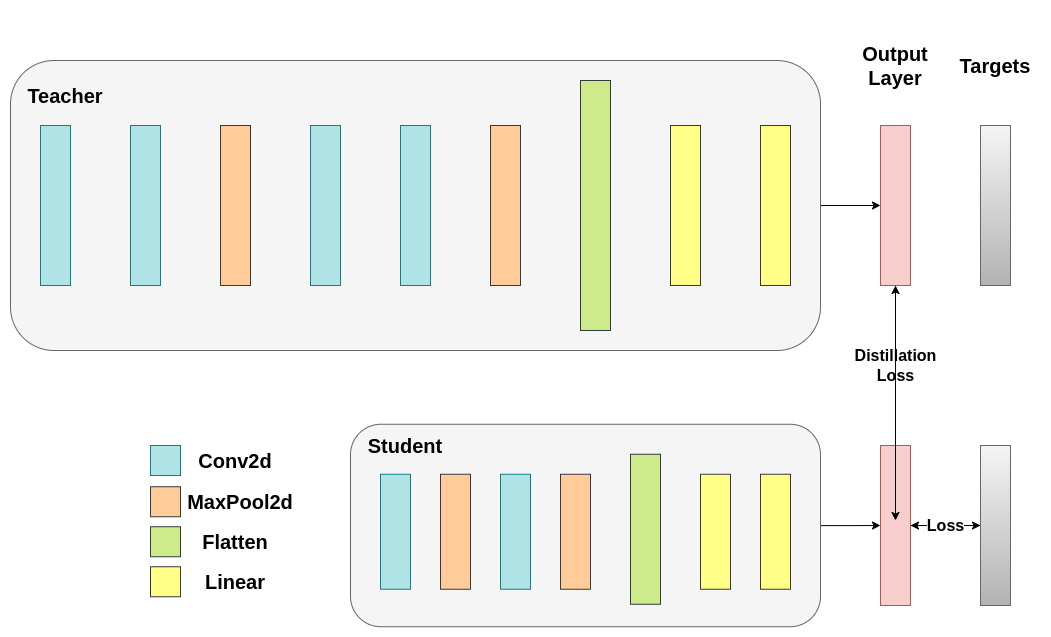

### Teacher-Student Training

In [13]:
"""
This loop trains a student model by learning from:

- The actual labels (normal training).

- The teacher model’s softened predictions, which give extra information like:

    Which wrong classes are still somewhat likely.

    Subtle patterns the teacher has learned.

This approach helps the student model perform better, especially if it’s smaller or less powerful.
"""

def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader: # iterate over the batches of data (inputs, labels) from train_loader
            inputs, labels = inputs.to(device), labels.to(device) # sending data to device (cpu/gpu)

            optimizer.zero_grad() # reset the gradients before the next backward pass

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad(): # to stop gradient updates, since teacher model is already trained.
                teacher_logits = teacher(inputs) #passes the data through the teacher model to get predictions (logits)

            # Forward pass with the student model
            student_logits = student(inputs) # same data passed through student model which we're training

            #Soften the student logits by applying softmax first and log() second
            """
            T is the temperature parameter — it smooths the logits, helping the student learn "dark knowledge" (subtle class probabilities).
            Teacher logits → softmax → soft_targets (probabilities)
            Student logits → log_softmax → soft_prob (log-probabilities)
            """

            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)


            """
            Computes a loss based on the difference between teacher's soft targets and student’s log-probabilities.
            This is similar to KL divergence (how one distribution differs from another).
            Multiplied by T², as recommended in Hinton's paper on distillation.
            """

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            """
            Combines the two types of loss:
            From soft targets (teacher's knowledge)
            From hard labels (ground truth)
            Weights (soft_target_loss_weight, ce_loss_weight) control how much to rely on each.
            """
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            """
            Backpropagates the combined loss.
            Updates student model's weights.
            """
            loss.backward()
            optimizer.step()

            #Adds current loss to a total, for logging or monitoring purposes.
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

# Apply ``train_knowledge_distillation`` with a temperature of 2. Arbitrarily set the weights to 0.75 for CE and 0.25 for distillation loss.
train_knowledge_distillation(teacher=nn_deep, student=new_nn_light, train_loader=train_loader, epochs=10, learning_rate=0.001, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device=device)
test_accuracy_light_ce_and_kd = test(new_nn_light, test_loader, device)

# Compare the student test accuracy with and without the teacher, after distillation
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_light_ce:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_light_ce_and_kd:.2f}%")

Epoch 1/10, Loss: 2.394736872304736
Epoch 2/10, Loss: 1.8772454219096153
Epoch 3/10, Loss: 1.6514142843158655
Epoch 4/10, Loss: 1.4894046030386026
Epoch 5/10, Loss: 1.3629392269627212
Epoch 6/10, Loss: 1.2457090887572149
Epoch 7/10, Loss: 1.1481730244348727
Epoch 8/10, Loss: 1.0599971936486872
Epoch 9/10, Loss: 0.9828206790072839
Epoch 10/10, Loss: 0.9125687804673334
Test Accuracy: 70.65%
Teacher accuracy: 75.04%
Student accuracy without teacher: 70.48%
Student accuracy with CE + KD: 70.65%
